In [1]:
import boto3
import pandas as pd
import matplotlib.pyplot as plt

dynamodb = boto3.resource('dynamodb', region_name="us-east-2")
table = dynamodb.Table('gym_usage')
data = table.scan()

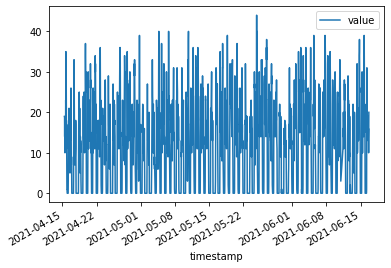

In [2]:
df = pd.DataFrame(data["Items"])
df["value"] = df["value"].astype("int")
df.index = pd.to_datetime(df["timestamp"])
df.drop(columns=["timestamp"])
df.plot()

In [3]:
df.describe()

,value
count,3064.000000
mean,12.129569
std,10.424292
min,0.000000
25%,0.000000
50%,13.000000
75%,20.000000
max,44.000000


In [4]:
df["time_of_day"] = (df.index.hour + df.index.minute // 10 / 6 + 1) % 24

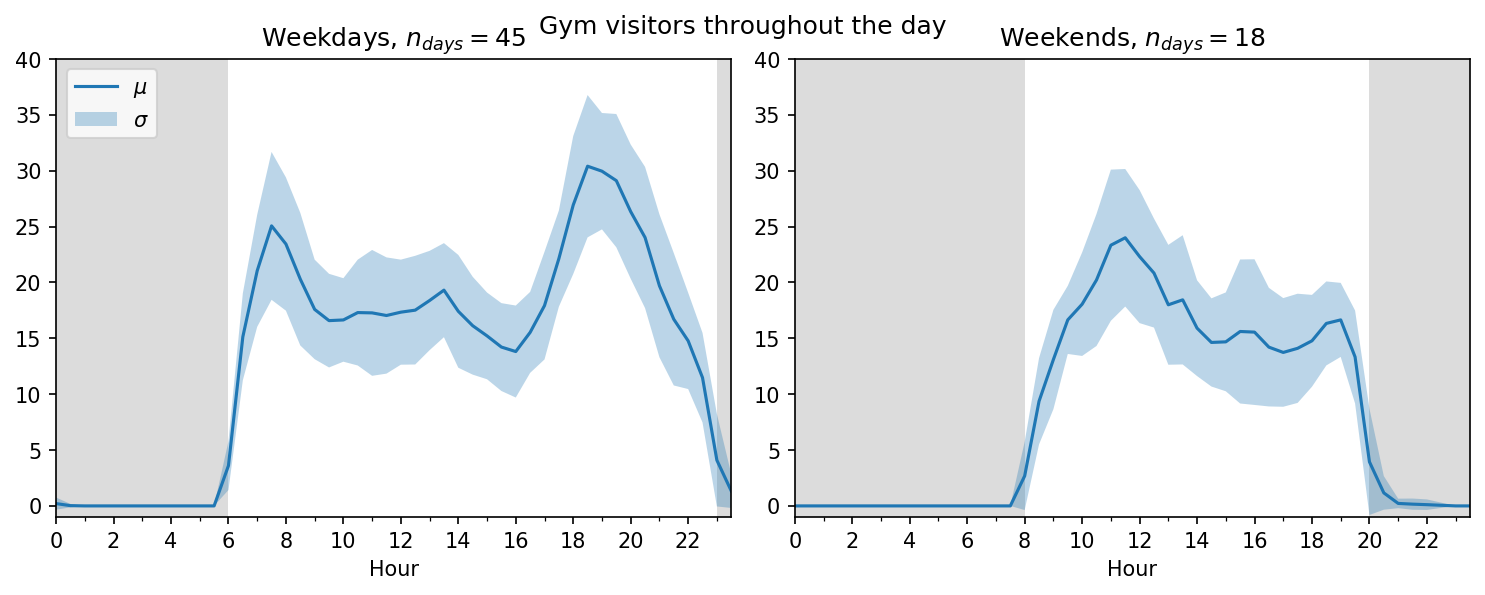

In [5]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

def get_plot(title, ax, data, opening_hours, legend=False):
    grouped = data.groupby("time_of_day")
    mean = grouped["value"].mean()
    std = grouped["value"].std()

    ax.set_facecolor("gainsboro")
    ax.axvspan(*opening_hours, color='w', lw=0, zorder=0)

    ax.plot(grouped.mean(), label="$\mu$")
    ax.fill_between(grouped.min().index, mean + std, mean - std, alpha=.3, label="$\sigma$")
    
    # ax.scatter(data["time_of_day"], data["value"], alpha=.7, s=3, c="black")

    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.xaxis.set_major_locator(MultipleLocator(2))
    ax.set_xlabel("Hour")
    ax.set_ylim(-1, 40)
    ax.set_xlim(0, 23.5)
    
    if legend:
        ax.legend(loc="best")
    ax.set_title(f"{title}, $n_{{days}}={len(data) // 48}$")

fig, (ax1, ax2) = plt.subplots(1, 2, dpi=150, figsize=(10, 4))
fig.suptitle("Gym visitors throughout the day")
get_plot("Weekdays", ax1, df[df.index.dayofweek < 5], (6, 23), legend=True)
get_plot("Weekends", ax2, df[df.index.dayofweek >= 5], (8, 20))
fig.tight_layout()


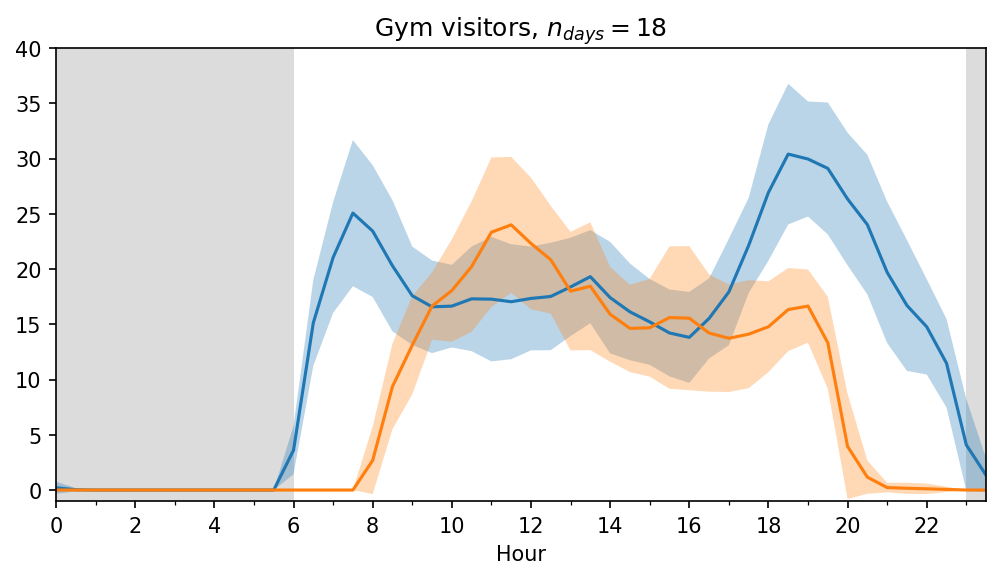

In [6]:
fig, ax = plt.subplots(1, dpi=150, figsize=(8, 4))
get_plot("", ax, df[df.index.dayofweek < 5], (6, 23))
get_plot("Gym visitors", ax, df[df.index.dayofweek >= 5], (6, 23))

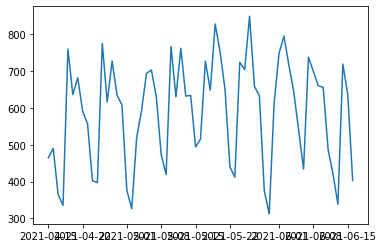

In [7]:
day_df = pd.DataFrame(df)
day_df["day"] = day_df.index.date
grouped = day_df.groupby("day").sum()
plt.plot(grouped.index, grouped["value"])

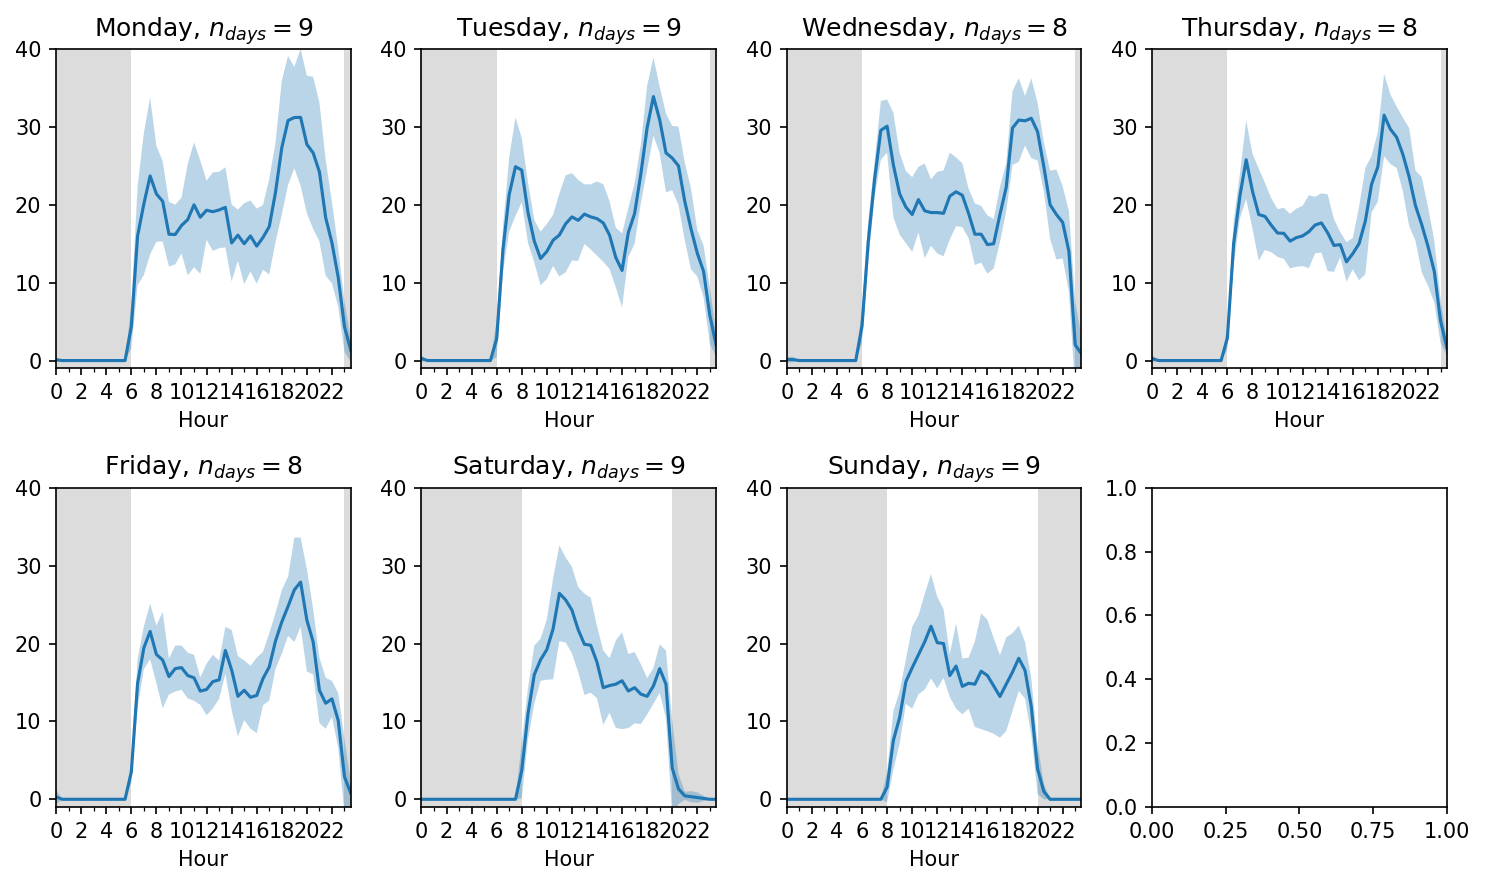

In [8]:
fig, axs = plt.subplots(2, 4, dpi=150, figsize=(10, 6))
axs = [x for sub in axs for x in sub]
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
hours = [(6, 23)] * 5 + [(8, 20)] * 2
axs = zip(range(7), axs[:7], days, hours)
# fig.suptitle("Gym visitors throughout the day")
for i, ax, day, hours in axs:
    get_plot(day, ax, df[df.index.dayofweek == i], hours, legend=False)
fig.tight_layout()

(0, 875.8587417218544)

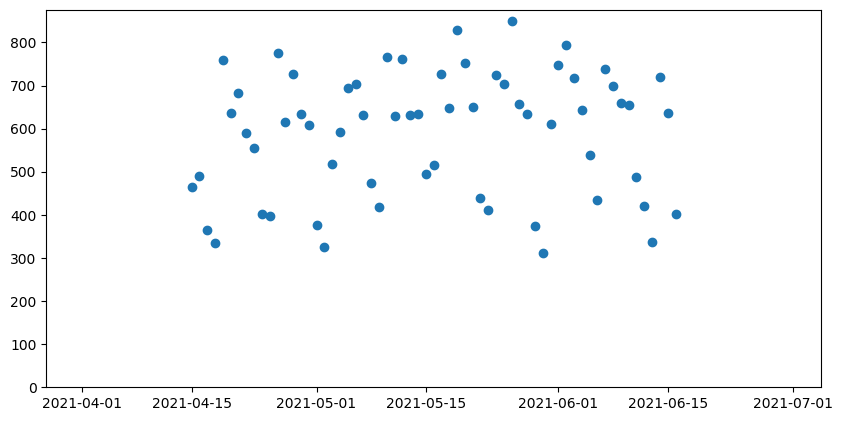

In [26]:
# day = df[df.index.dayofweek == 2].groupby("day").sum()
day = df.groupby("day").sum()
fig, ax = plt.subplots(dpi=100, figsize=(10, 5))
ax.scatter(day.index, day["value"])
ax.set_ylim(ymin=0)
